In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [2]:
import wandb
config = {
    'log_interval': 1,
}
wandb.init(project="ann_mnist")

wandb: Currently logged in as: kilian (use `wandb login --relogin` to force relogin)


In [3]:
batch_size = 32

In [4]:
xTest2 = np.fromfile('xTest2.bin', dtype=np.uint8)
xTest2 = xTest2.reshape([28, 28, 1, 10000])

In [5]:
xTest2[:,:,:,1].shape

(28, 28, 1)

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

In [7]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_valset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [8]:
train_dataloader = torch.utils.data.DataLoader(mnist_trainset,
                                                batch_size=batch_size,
                                                shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset,
                                            batch_size=batch_size,
                                            shuffle=False)

In [9]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

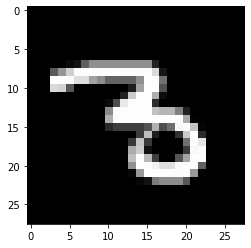

/home/kilian/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor(3)

In [10]:
# show images
idx = 30
imshow(torchvision.utils.make_grid(train_dataloader.dataset.data[idx]))
train_dataloader.dataset.train_labels[idx]

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(864,32)
        self.fc2 = nn.Linear(32, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
# Magic
wandb.watch(net, log_freq=100)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        if i % config['log_interval'] == 0:
            wandb.log({"loss": loss})

print('Finished Training')

Finished Training


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {}'.format(
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95.97


In [16]:
targets = val_dataloader.dataset.targets.unique().numpy()
targets_correct = {target: 0 for target in targets}
targets_count = {target: 0 for target in targets}

with torch.no_grad():
    for (images, labels) in val_dataloader:
        outputs = net(images)
        _, predictions = torch.max(outputs.data, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                targets_correct[targets[label]] += 1
            targets_count[targets[label]] += 1

for classname, correct_count in targets_correct.items():
    accuracy = 100 * float(correct_count) / targets_count[classname]
    print("Accuracy for class {} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class 0 is: 98.5 %
Accuracy for class 1 is: 97.3 %
Accuracy for class 2 is: 98.2 %
Accuracy for class 3 is: 94.9 %
Accuracy for class 4 is: 98.2 %
Accuracy for class 5 is: 96.0 %
Accuracy for class 6 is: 94.9 %
Accuracy for class 7 is: 92.8 %
Accuracy for class 8 is: 96.3 %
Accuracy for class 9 is: 92.8 %
